# SuperComp - Relatório final do projeto 
### Beatriz Muniz de Castro e Silva

Nesse relatório, entraremos em detalhe em técnicas e algoritmos para o problema de alinhamento de sequências de DNA. Dentre as técnicas observadas, iremos analisar a Heurística de Alinhamento de Smith-Waterman, um algoritmo de Busca Local com Aleatoriedade e um algoritmo de Busca Exaustiva.

O problema de alinhamento de sequências de DNA consiste em comparar duas sequências de DNA para determinar o nível de similaridade das duas, também chamado de score. O score de duas sequências é determinado através de pesos, onde um acerto soma +2 ao score (match, também chamado de wmat), e um erro subtrai -1 do score (gap e mismatch, ou wmis e wgap). Os pesos são utilizados no cálculo do score em todos os algoritmos, mas cada algoritmo chega em um score para as duas subsequências de modos diferentes.


![title](relatorio/alignment.png)

Na imagem acima, as letras em verde representam match, as letras em azul representam gap e as letras em vermelho representam mismatch

## Heurística de Smith-Waterman

A Heurística de Smith-Waterman é um método conhecido para calcular o score de duas subsequências de DNA. Diferente dos outros métodos, ele organiza as duas sequências em uma matriz, com as fileiras inicias zeradas, e calcula para cada par o score da diagonal, deleção e inserção (salto diagonal, salto de cima para baixo e salto da esquerda para a direita, respectivamente). Ele determina o maior valor desses três para cada par para criar a matriz, e em seguida seleciona o maior valor na matriz e faz o processo reverso até chegar em um valor 0, de modo a pegar um caminho que leve ao maior score na matriz.

A imagem em seguida mostra um exemplo de uma matriz de Smith-Waterman, utilizando as subsequências AATCG e AACG e os pesos já definidos de +2 para match e -1 para gap e mismatch:

![title](relatorio/sm1.png)

Na imagem, as setas representam o caminho tomado para o maior score possível. Os possíveis passos que podem ser tomados, a partir de qualquer par, são:

![title](relatorio/sm2.png)

Onde um salto na diagonal representa match, um salto de cima para baixo representa que houve uma deleção e um salto da esquerda para a direita representa uma inserção. No exemplo apresentado, o resultado da comparação das duas sequências é o seguinte:

![title](relatorio/sm3.png)

## Busca Local com Aleatoriedade

A busca local com aleatoriedade busca pegar um score alto através de aleatoriedade. O algoritmo corta a primeira sequência de entrada em uma subsequência de tamanho aleatório K, em um index aleatório I, e seleciona uma quantidade aleatória P de subsequências da segunda entrada com tamanho K, e compara a primeira subsequência com as P subsequências geradas. Ele retorna então o maior score encontrado. Como é utilizado aleatoriedade e nem todas as possíveis combinações são testadas, o maior valor encontrado pode variar a cada vez que o algoritmo é rodado.

## Busca Exaustiva

A busca exaustiva separa as duas sequências de entrada em todas as possíveis subsequências, de todos os tamanhos possíveis, em duas listas. Depois ele compara todas as subsequêcias existentes, de modo a encontrar as subsequências que possuem o maior score nas entradas. Esse algoritmo sempre retorna o melhor score, e sempre o mesmo resultado, porém como ele passa por todas as possíveis subsequências das entradas, ele demora mais para encontrar o score máximo do que os métodos de Smith Waterman e de Busca Local com Aleatoriedade.

## Paralelismo com CPU

Um dos métodos possíveis de optimizar códigos é através do Paralelismo, de modo que partes repetitivas do código podem ser separadas e rodadas simultâneamente. Foi requisitado que um dos algoritmos acima fosse escolhido para ser paralelizado, mais especificamente aquele que aparentasse possuir um benefício maior de ser paralelizado. O algoritmo escolhido foi o Busca Exaustiva. 

Um método de se alcançar o paralelismo é através do OpenMp, uma tecnologia de computação multi-core que divide os subprocessos entre os cores do CPU. A parte do código que foi paralelizada foi o cálculo do score das substrings.

## Paralelismo com GPU

Outro método de se paralelizar um código é através do método many-core, utilizando uma GPU. Foi utilizado nessa análise a biblioteca Thrust e o toolkit CUDA, ambos da NVIDIA, para realizar a paralelização many-core da Busca Exaustiva. Porém, nesse caso, o cálculo do score foi feito através da heurística de Smith-Waterman, portanto não pode ser diretamente comparado ao paralelismo em CPU. Assim como no CPU, foi paralelizado o cálculo do score da matriz.

## Análise dos algoritmos

Imports necessários

In [1]:
import subprocess
import time
import os
import matplotlib.pyplot as plt
import numpy as np
import random
from re import sub
import plotly.graph_objects as go

Para gerar as sequências de entrada, foi utilizado o arquivo seqGen.py, que cria diversos arquivos de entrada de acordo com os parâmetros escolhidos. Nessa análise foram utilizados arquivos de entrada com tamanhos M e N máximos de 250, pois valores acima disso demorariamm demais para rodar nos algoritmos de busca exaustiva, incluindo os de paralelismo. Foram feitas entradas com um intervalo de 25 em 25, de modo que 250 entradas foram utilizadas. Essas entradas foram salvas em arquivos txt na pasta inputs. Em seguida, rodamos os algoritmos com as entradas e salvamos os tempos de execução dos algoritmos de cada entrada nos arquivos txt encontrados na pasta resultados. 

In [25]:
list_alg = {'./main' : 'Smith Waterman', './local' : 'Busca Local', './exa' : 'Busca Exaustiva', './parallel_cpu' : 'Paralelismo CPU', './parallel_gpu' : 'Paralelismo GPU'}

inputFiles = os.listdir("./inputs")
inputFiles.sort()
for i in list_alg:
    resultFile = f"{list_alg[i]}.txt"
    r = open(resultFile, 'w')
    for inputF in inputFiles:
        with open("./inputs/" + inputF) as f:
            start = time.perf_counter()
            proc = subprocess.run([i], input=f.read(), text=True, capture_output=True)
            end = time.perf_counter()
            r.write(f"{end - start}\n")
    r.close()

O código abaixo apenas serve para criar as variáveis que lêem os arquivos de resultado, fazendo uma filtragem no nome do arquivo para criar variáveis dinâmicas com o nome do arquivo em camelCase. 

In [10]:
def camel_case(s):
    s = s.replace(".txt", "")
    s = sub(r"(_|-)+", " ", s).title().replace(" ", "")
    return ''.join([s[0].lower(), s[1:]])

Em seguida nós preparamos os dados para criar os gráficos em 3D, organizando os resultados em matrizes de acordo com os tamanhos de M e N, além de deixar a primeira coluna e a primeira fileira zerada

In [33]:
results = os.listdir("./resultados")

for result in results:
    with open("./resultados/" + result) as f:
        # Para conseguir criar as variáveis dinâmicamente, utilizando o nome do arquivo, utilizamos o local() para mexer na symbol table local diretamente
        locals()[camel_case(result)] = f.read()

smithWaterman = smithWaterman.split('\n')
buscaLocal = buscaLocal.split('\n')
buscaExaustiva = buscaExaustiva.split('\n')
paralelismoCpu = paralelismoCpu.split('\n')
paralelismoGpu = paralelismoGpu.split('\n')


smithWaterman = [float(i) for i in smithWaterman]
buscaLocal = [float(i) for i in buscaLocal]
buscaExaustiva = [float(i) for i in buscaExaustiva]
paralelismoCpu = [float(i) for i in paralelismoCpu]
paralelismoGpu = [float(i) for i in paralelismoGpu]

sH = [0 for x in range(11)]
blH = [0 for x in range(11)]
beH = [0 for x in range(11)]
pcH = [0 for x in range(11)]
pgH = [0 for x in range(11)]

i=0
while(i < len(smithWaterman)):
    if (i%10 == 0):
        sH.append(0)
        blH.append(0)
        beH.append(0)
        pcH.append(0)
        pgH.append(0)
    sH.append(smithWaterman[i])
    blH.append(buscaLocal[i])
    beH.append(buscaExaustiva[i])
    pcH.append(paralelismoCpu[i])
    pgH.append(paralelismoGpu[i])
    i+=1

sH = np.resize(sH, (11,11))
blH = np.resize(blH, (11,11))
beH = np.resize(beH, (11,11))
pcH = np.resize(pcH, (11, 11))
pgH = np.resize(pgH, (11, 11))

m = np.linspace(0, 250, 11)
n = np.linspace(0, 250, 11)

## Análise dos gráficos 3D

Para criar os gráficos em 3D dos tempos de execução, utilizamos a biblioteca plotly. Através dela, fazemos gráficos onde mostramos o tempo de execução em relação aos tamanhos M e N das entradas.

In [27]:
fig = go.Figure(go.Surface(
    x = m,
    y = n,
    z = sH))
fig.update_layout(
    scene = dict(
        xaxis_title='Tamanho N',
        yaxis_title='Tamanho M',
        zaxis_title='Tempo de Execução'),
    title={'text': "Smith-Waterman"},
    width=1000,
    height=700
)

fig.show()

fig = go.Figure(go.Surface(
    x = m,
    y = n,
    z = blH))
fig.update_layout(
    scene = dict(
        xaxis_title='Tamanho N',
        yaxis_title='Tamanho M',
        zaxis_title='Tempo de Execução'),
    title={'text': "Busca-Local"},
    width=1000,
    height=700
)

fig.show()

fig = go.Figure(go.Surface(
    x = m,
    y = n,
    z = beH))
fig.update_layout(
    scene = dict(
        xaxis_title='Tamanho N',
        yaxis_title='Tamanho M',
        zaxis_title='Tempo de Execução'),
    title={'text': "Busca-Exaustiva"},
    width=1000,
    height=700
)

fig.show()

No gráfico de Smith Waterman, podemos ver diversos pontos de pico que criam ruídos, aparentemente aleatórios. Isso pode possivelmente ser explicado pelo timeout de threads, onde quando ocorre timeout no tempo de execução de uma thread de um processo antes do teste completar de rodar, ele é alocado à outra thread, causando um aumento no tempo de execução. Apesar do ruído, é possível notar que o tempo de execução varia dependente dos tamanhos de M e N das entradas.

No gráfico da Busca Local, temos um caso mais difícil de examinar. O gráfico aparenta que o programa apenas roda quando N possui um valor similar a M, e vice versa. Isso pode ser explicado pois o meu código, apesar de utilizar os mesmos métodos de ler os arquivos de entrada do que os outros métodos, tem problemas em pegar a entrada da segunda sequência. Depois de tentar de diversos modos diferentes arrumar o problema, ele se manteve. Porém é possível ver no gráfico que apesar que há uma leve curva que pode descrever uma dependência de tanto N quanto M no tempo de execução.

Já no gráfico da Busca Exaustiva, fica bem claro como o tempo de execução é dependente de tanto M quanto N, vendo que ele calcula todas as possíveis substrings e as compara. 

Também é possível ver nos gráficos que o algoritmo de Smith Waterman possui um tempo de execução muito menor do que os outros métodos, seguido da Busca Local e da Busca Exaustiva. O resultado é esperado, principalmente vendo que enquanto o Busca Local compara apenas algumas substrings, a Busca Exaustiva compara todas as possíveis substrings, e por isso deve ter um tempo de execução maior.

## Profiling

Apesar de possuirmos os tempos de execução de cada código, podemos ainda realizar um profiling em cada um para determinar áreas do código que tomam mais tempo para ser executadas, ou que podem ser mais beneficiadas de uma optimização. Realizamos essa análise através do Valgrind. Todos os processos foram examinados com a entrada 250n025m.seq, da pasta inputs.

### Smith Waterman

![title](relatorio/smith-w.png)

No código de Smith Waterman, a parte do código que demora mais tempo para ser executada é o loop interno de criação da matriz.

### Busca Local

![title](relatorio/busca-l.png)

No código de Busca Local, a parte do código que mais demora para ser executada é o cálculo do score das subsequências.

### Busca Exaustiva

![title](relatorio/busca-ex.png)

Na Busca Exaustiva, a parte do código que mais demora para ser executada é o cálculo e comparação dos scores das subsequências.

## Análise de Paralelismo

Para analisar a performance do paralelismo, vamos utilizar gráficos 2D para criar uma comparação mais direta dos algoritmos

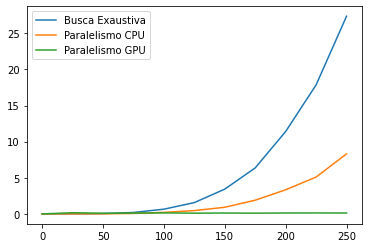

In [34]:
be2d = [beH[x,x] for x in range(0,11)]
cpu2d = [pcH[x,x] for x in range(0,11)]
gpu2d = [pgH[x,x] for x in range(0,11)]
plt.plot(m, be2d, label = "Busca Exaustiva")
plt.plot(m, cpu2d, label = "Paralelismo CPU")
plt.plot(m, gpu2d, label = "Paralelismo GPU")
plt.legend()
plt.show()

O gráfico acima confirma que a paralelização ajuda no tempo de execução da busca exaustiva. Assim como esperado, tando o paralelismo por CPU quanto por GPU possuem um tempo de execução mais baixo do que o da busca exaustiva. Vamos também fazer uma análise da parte mais inicial do gráfico, onde as entradas são menores.

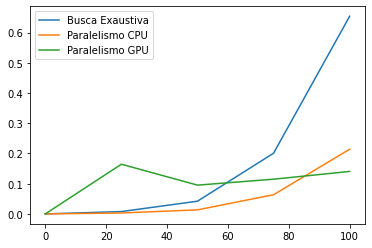

In [37]:
be2d = [beH[x,x] for x in range(0,5)]
cpu2d = [pcH[x,x] for x in range(0,5)]
gpu2d = [pgH[x,x] for x in range(0,5)]
men = np.linspace(0, 100, 5)
plt.plot(men, be2d, label = "Busca Exaustiva")
plt.plot(men, cpu2d, label = "Paralelismo CPU")
plt.plot(men, gpu2d, label = "Paralelismo GPU")
plt.legend()
plt.show()

No paralelismo em CPU, é possível ver que a curva é constante, sem grandes picos, devido ao fato de que os dados utilizados já estão presentes na CPU, portanto o ato de paralelizar nos cores é mais direto do que no caso do paralelismo em GPU, onde é necessário criar vetores na memória da GPU e transferir os dados da memória da CPU para a da GPU. 

A GPU também aparenta ser menos efetiva com entradas mais baixas, possivelmente devido ao tempo extra alocado à transferência de arquivos, porém com entradas maiores, ela acaba sendo mais efetiva do que a CPU. 

Vale lembrar que apesar de ambos os processos garantirem o score máximo, o score em si é calculado de modos diferentes nos dois paralelismos. No GPU, apesar de o algoritmo ser exaustivo, checando todas as subsequências, o cálculo do score é feito através de matrizes, assim como é feito no algoritmo de Smith Waterman. Isso pode levar à um tempo maior de execução, porém como a paralelização de GPU costuma ser mais rápida do que a de CPU, como podemos ver, esse fator acaba sendo irrelevante na análise.

## Conclusão

Em geral, podemos dizer que o Smith Waterman é o algoritmo mais rápido dentre os sequenciais para encontrar os scores, porém como ele faz manipulação das sequências (inserção e deleção), o score calculado não pode ser diretamente comparado aos scores encontrados nas outras buscas. Em relação às buscas, a Busca Exaustiva garante o melhor score, porém demora muito mais do que a Busca Local, que nem sempre devolve o mesmo score para a mesma entrada, portanto a decisão de optar entre um e o outro depende das necessidades e limitações de tempo do usuário.

Vemos também na análise de paralelismo que a paralelização acaba diminuindo de maneira significativa o tempo de execução da busca exaustiva, com o paralelismo em GPU sendo mais efetivo do que o paralelismo em CPU, porém isso se percebe mais com entradas maiores, vendo que entradas muito pequenas acabam tendo um tempo de execução maior do que a CPU.